In [9]:
import zipfile
from tqdm import tqdm
import os
import pandas as pd

In [ ]:
zip_path = '/content/drive/MyDrive/Proyecto Cultivos/deepglobe.zip'

In [ ]:
# Decompress

extracted_folder = '/content/drive/MyDrive/Proyecto Cultivos/deepglobe'

if not os.path.exists(extracted_folder):
  os.makedirs(extracted_folder)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  for file in tqdm(zip_ref.namelist(), desc='Extracting'):
    zip_ref.extract(file, extracted_folder)

Extracting: 100%|██████████| 1951/1951 [01:20<00:00, 24.23it/s]


In [10]:
# Extract to visualize
data_path = '/content/drive/MyDrive/Proyecto Cultivos/deepglobe'

metadata_df = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(data_path, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(data_path, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# 90/10 split for train / val
df_val = metadata_df.sample(frac=0.1, random_state=42)
df_train = metadata_df.drop(df_val.index)
len(df_train), len(df_val)

(723, 80)

In [ ]:
df_classes = pd.read_csv(os.path.join(data_path, 'class_dict.csv'))

print(df_classes.head(10))

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [ ]:
print(df_train.head())

   image_id                                     sat_image_path  \
0    273274  /content/drive/MyDrive/Proyecto Cultivos/deepg...   
1    269601  /content/drive/MyDrive/Proyecto Cultivos/deepg...   
2    924236  /content/drive/MyDrive/Proyecto Cultivos/deepg...   
3    181447  /content/drive/MyDrive/Proyecto Cultivos/deepg...   
4       606  /content/drive/MyDrive/Proyecto Cultivos/deepg...   

                                           mask_path  
0  /content/drive/MyDrive/Proyecto Cultivos/deepg...  
1  /content/drive/MyDrive/Proyecto Cultivos/deepg...  
2  /content/drive/MyDrive/Proyecto Cultivos/deepg...  
3  /content/drive/MyDrive/Proyecto Cultivos/deepg...  
4  /content/drive/MyDrive/Proyecto Cultivos/deepg...  


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 723 entries, 0 to 802
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_id        723 non-null    int64 
 1   sat_image_path  723 non-null    object
 2   mask_path       723 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


In [11]:
# Muestra imágenes

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def display_mask(mask_path):
    mask = Image.open(mask_path)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

def get_mask_meaning(mask_path, color_mapping_df):
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)

    color_mapping_dict = {}
    for _, row in color_mapping_df.iterrows():
        color_mapping_dict[(row['r'], row['g'], row['b'])] = row['name']
    meanings = []
    for color in unique_colors:
        meanings.append(color_mapping_dict.get(tuple(color), 'unknown'))

    return meanings

Mask meanings for image 1: ['forest_land', 'urban_land', 'rangeland', 'agriculture_land']
Mask meanings for image 2: ['water', 'urban_land', 'rangeland', 'agriculture_land']
Mask meanings for image 3: ['water', 'urban_land', 'agriculture_land']
Mask meanings for image 4: ['unknown', 'water', 'urban_land', 'rangeland', 'agriculture_land', 'barren_land']


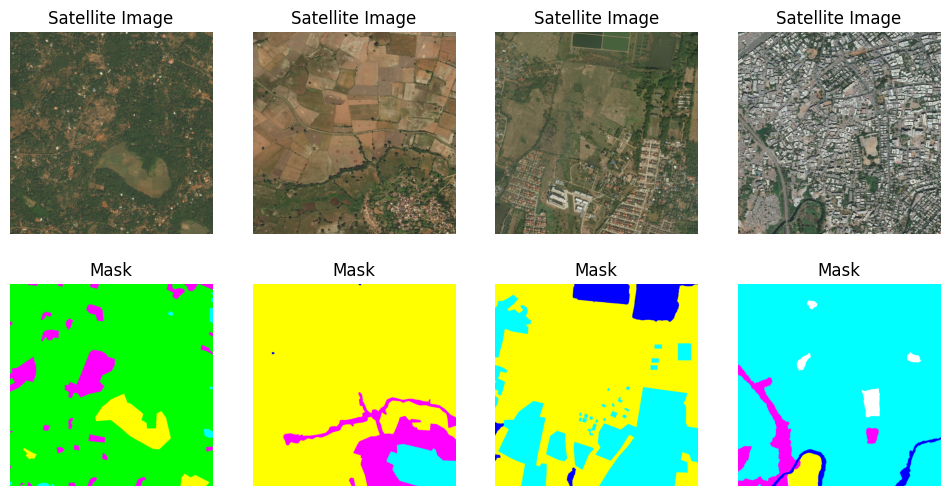

In [12]:
import random

# Create a 2x4 grid of subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    index = random.choice(range(len(df_train)))
    row = df_train.iloc[index]
    sat_img_path = row['sat_image_path']
    mask_path = row['mask_path']
    mask_meanings = get_mask_meaning(mask_path, df_classes)

    # Display the satellite image
    axs[0, i].imshow(Image.open(sat_img_path))
    axs[0, i].set_title("Satellite Image")
    axs[0, i].axis('off')

    # Display the mask
    axs[1, i].imshow(Image.open(mask_path), cmap='gray')
    axs[1, i].set_title("Mask")
    axs[1, i].axis('off')

    # Print mask meanings
    print(f"Mask meanings for image {i + 1}: {mask_meanings}")

plt.show()




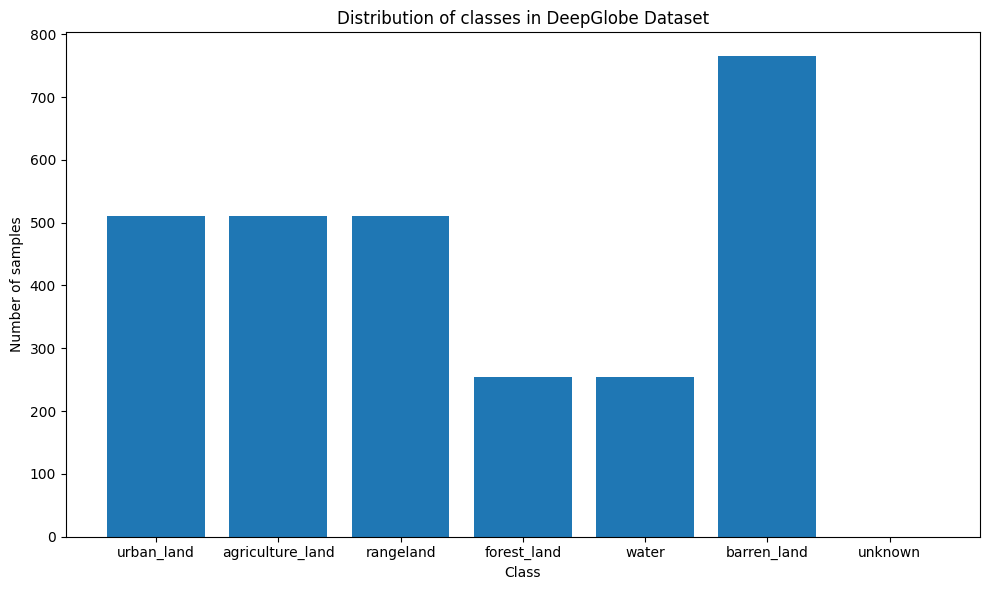

In [ ]:
# Class distribution:

import matplotlib.pyplot as plt


df_classes['count'] = df_classes[['r', 'g', 'b']].sum(axis=1)

plt.figure(figsize=(10, 6))
plt.bar(df_classes['name'], df_classes['count'])
plt.title('Distribution of classes in DeepGlobe Dataset')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks()
plt.tight_layout()
plt.show()